<a href="https://colab.research.google.com/github/ambideXtrous9/Quantization-of-Models-PTQ-and-QAT/blob/main/Quantization_PTQ_and_QAT_on_CNN_using_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
shaunthesheep_microsoft_catsvsdogs_dataset_path = kagglehub.dataset_download('shaunthesheep/microsoft-catsvsdogs-dataset')

print('Data source import complete.')


In [ ]:
!pip3 install -q nomkl

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import pandas as pd
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')


2024-12-29 08:50:02.744846: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-29 08:50:02.744969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-29 08:50:03.016478: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available: 2


In [ ]:
# Define your dataset folder path
dataset_path = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages'

In [ ]:
# Function to check if an image file is valid
def is_valid_image(file_path):
    try:
        # Open and check if the image can be loaded
        Image.open(file_path)
        return True
    except (IOError, SyntaxError):
        # Invalid image file
        return False

In [ ]:

# Filter out valid images and create a list of file paths and labels
file_paths = []
labels = []


for label in ['Cat', 'Dog']:
    label_folder = os.path.join(dataset_path, label)
    for file_name in os.listdir(label_folder):
        file_path = os.path.join(label_folder, file_name)
        if is_valid_image(file_path):
            file_paths.append(file_path)
            labels.append('Cat' if label == 'Cat' else 'Dog')  # Convert label to string

# Convert lists to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)



In [ ]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

train_file_paths, test_file_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42, stratify=labels)




In [ ]:
# Define data generators for training and testing
batch_size = 64

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_file_paths, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(28, 28),  # adjust target_size as needed
    batch_size=batch_size,
    class_mode='categorical',  # binary classification
    shuffle=True)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': test_file_paths, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=(28, 28),  # adjust target_size as needed
    batch_size=batch_size,
    class_mode='categorical',  # binary classification
    shuffle=False)

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
for batch in test_generator:
    # Extract the first image and label from the batch
    image = batch[0][0]  # First image in the batch
    label = batch[1][0]  # Corresponding label

    # Print the label (0 for Cat, 1 for Dog)
    print(label)

    break



[0. 1.]


In [ ]:
class_indices = test_generator.class_indices

# Invert the dictionary to map indices to class names
class_names_mapping = {v: k for k, v in class_indices.items()}

# Check which class is mapped to class 0 and which to class 1
class_0 = class_names_mapping[0]
class_1 = class_names_mapping[1]

print(f"Class 0 is mapped to '{class_0}'")
print(f"Class 1 is mapped to '{class_1}'")


Class 0 is mapped to 'Cat'
Class 1 is mapped to 'Dog'


# **Model without Quantization**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation, Dropout
from tensorflow.keras.initializers import RandomNormal, Constant

In [ ]:
def custom_cnn(num_classes=2):
    model = Sequential()

    # Block 1
    model.add(Conv2D(16, (3, 3), strides=(1, 1), padding='same', input_shape=(28, 28, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Block 2
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Flatten the output before adding FC layers
    model.add(Flatten())

    # Fully Connected (FC) layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Add dropout for regularization
    model.add(Dense(num_classes, activation='softmax'))

    return model


In [ ]:
# Create an instance of the CustomCNN model
model = custom_cnn()

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       200,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,370 (806.13 KB)

 Trainable params: 206,274 (805.76 KB)

 Non-trainable params: 96 (384.00 B)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the filepath for saving the best model
checkpoint_filepath = 'best_model.keras'

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',  # monitor validation accuracy
    verbose=1,
    save_best_only=True,
    mode='max'
)

In [ ]:

# Train the model
epochs = 15

# Calculate steps per epoch for training
steps_per_epoch = train_generator.samples // batch_size

# Calculate validation steps for validation
validation_steps = test_generator.samples // batch_size

# Train the model with the callback
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback]  # Pass the ModelCheckpoint callback
)

Epoch 1/15
  3/312 ━━━━━━━━━━━━━━━━━━━━ 26s 86ms/step - accuracy: 0.5373 - loss: 1.3954

I0000 00:00:1735462454.255139     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1735462454.270372     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


286/312 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.6113 - loss: 0.7764

W0000 00:00:1735462502.621105     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


306/312 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.6130 - loss: 0.7691

W0000 00:00:1735462507.073723     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.60837, saving model to best_model.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 74s 207ms/step - accuracy: 0.6136 - loss: 0.7668 - val_accuracy: 0.6084 - val_loss: 0.8577
Epoch 2/15
  1/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7031 - loss: 0.5902
Epoch 2: val_accuracy did not improve from 0.60837
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7031 - loss: 0.5902 - val_accuracy: 0.5000 - val_loss: 1.3369
Epoch 3/15
306/312 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.6921 - loss: 0.5774
Epoch 3: val_accuracy improved from 0.60837 to 0.66667, saving model to best_model.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 60s 190ms/step - accuracy: 0.6923 - loss: 0.5773 - val_accuracy: 0.6667 - val_loss: 0.5990
Epoch 4/15
  1/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7656 - loss: 0.4898
Epoch 4: val_accuracy did not improve from 0.66667
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 37us/step - accuracy: 0.7656 - loss: 0.4898 - val_accuracy: 0.5000 - val_

In [ ]:
model = tf.keras.models.load_model(checkpoint_filepath)

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy}')

 3/79 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.7951 - loss: 0.4317  

W0000 00:00:1735462935.791267     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.7773 - loss: 0.4796
Test accuracy: 0.7688000202178955


In [ ]:
model.export("test", "tf_saved_model")

Saved artifact at 'test'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  136091542773200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136091544457232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136091147252512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136091147240368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136091147245648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136091147239840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136090939608048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136090939607696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136090939611568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136090939614208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136090939612800: TensorSpec(s

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:

def predimg(Pet = "Cat",Num = 20):

    model = tf.keras.models.load_model('best_model.keras')

    img_path = f"/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/{Pet}/{Num}.jpg"  # Specify the correct image path
    img = image.load_img(img_path, target_size=(28, 28))  # Resize to the input size of the model

    # Preprocess the image (convert to array, normalize, etc.)
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize to [0, 1]

    # Perform inference
    predictions = model.predict(img_array)

    # Output the prediction (the class with the highest probability)
    predicted_class = np.argmax(predictions, axis=1)
    print(f'Predicted Class: {predicted_class[0]}')

    # Optionally, if you want to know the probability distribution
    print(f'Prediction probabilities: {predictions}')

    predicted_class_name = class_names_mapping[predicted_class[0]]
    print(f"Predicted class name: {predicted_class_name} with Confidence = {predictions[0][predicted_class[0]]}")

    # Display the image
    import matplotlib.pyplot as plt

    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
Predicted Class: 0
Prediction probabilities: [[0.8420505  0.15794957]]
Predicted class name: Cat with Confidence = 0.8420504927635193


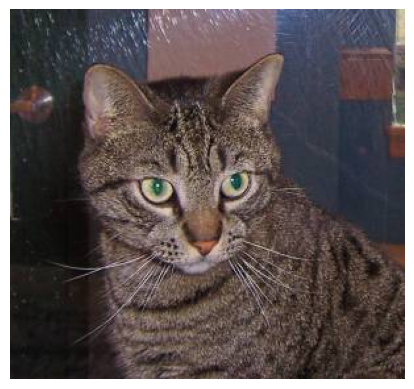

In [ ]:
predimg(Pet = "Cat",Num = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
Predicted Class: 1
Prediction probabilities: [[0.10773157 0.8922684 ]]
Predicted class name: Dog with Confidence = 0.8922684192657471


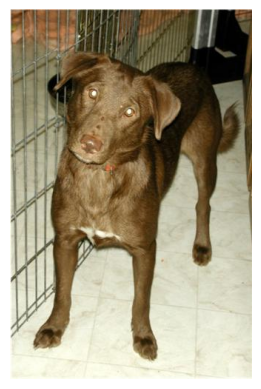

In [ ]:
predimg(Pet = "Dog",Num = 1)

In [ ]:
# Print the size of the model
model_size = os.path.getsize('best_model.keras')
print(f"Model size Without Qunatization: {model_size / (1024):.2f} KB")

Model size Without Qunatization: 2461.23 KB


# **Post Training Quantization**


In [ ]:
def representative_dataset():
    counter = 0
    for image_batch, labels_batch in test_generator:
        yield [image_batch]
        counter += 1
        if counter >= 100:
            break


In [ ]:
representative_dataset()

<generator object representative_dataset at 0x7bc605d522d0>

In [ ]:
import tensorflow as tf

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("test")

converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.representative_dataset = representative_dataset

converter.target_spec.supported_ops =[tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type  = tf.float32

converter.inference_output_type = tf.int8

In [ ]:
def np_softmax(output_data):
    # Subtract max to avoid numerical overflow during exponentiation
    shift_output_data = output_data - np.max(output_data, axis=-1, keepdims=True)
    exp_output_data = np.exp(shift_output_data)
    softmax_output = exp_output_data / np.sum(exp_output_data, axis=-1, keepdims=True)
    return softmax_output

In [ ]:

quantiz_model = converter.convert()

open("PTQModel.tflite", "wb").write(quantiz_model)

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 13, Total Ops 28, % non-converted = 46.43 %
 * 13 ARITH ops

- arith.constant:   13 occurrences  (f32: 12, i32: 1)



  (f32: 2)
  (f32: 2)
  (f32: 2)
  (f32: 2)
  (f32: 2)
  (f32: 1)
  (f32: 1)
fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: INT8


213880

In [ ]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/kaggle/working/PTQModel.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [ ]:
# Prepare the image
def preprocess_image(image_path, input_shape):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((input_shape[1], input_shape[2]))
    img = np.array(img, dtype=np.float32)
    img = np.expand_dims(img, axis=0)
    img = img / 128 - 1
    return img

In [ ]:
def predimage(Pet="Dog",Num=20):
    # Load and preprocess the image
    image_path=f"/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/{Pet}/{Num}.jpg"
    input_shape = input_details[0]['shape']
    image = preprocess_image(image_path, input_shape)

    # Set the tensor
    interpreter.set_tensor(input_details[0]['index'], image)

    # Run the inference
    interpreter.invoke()

    # Get the output
    output_data = interpreter.get_tensor(output_details[0]['index'])
    # Get predicted label
    output_data = np_softmax(output_data)
    predicted_label = np.argmax(output_data, axis=1)[0]


    # Print the predicted label
    print(f"Output Data : {output_data}")
    print(f"Predicted class: {predicted_label}")
    predicted_class_name = class_names_mapping[predicted_label]
    print(f"Predicted class name: {predicted_class_name} with Confidence = {output_data[0][predicted_label]}")


    # Display the image
    import matplotlib.pyplot as plt

    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


Output Data : [[ 0. nan]]
Predicted class: 1
Predicted class name: Dog with Confidence = nan


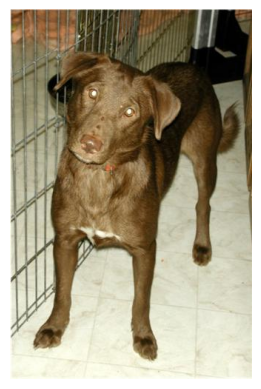

In [ ]:
predimage(Pet="Dog",Num=1)

Output Data : [[ 0. nan]]
Predicted class: 1
Predicted class name: Dog with Confidence = nan


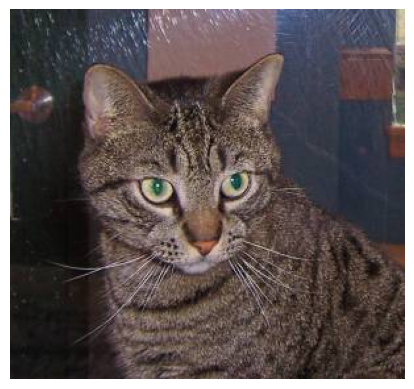

In [ ]:
predimage(Pet="Cat",Num=1)

In [ ]:
# Print the size of the model
tflite_model_path = 'PTQModel.tflite'
model_size = os.path.getsize(tflite_model_path)
print(f"PTQ Model size: {model_size / (1024):.2f} KB")

PTQ Model size: 208.87 KB


# **QAT : Quantization Aware Training**

In [ ]:
! pip install -q tensorflow-model-optimization


In [ ]:
from tensorflow_model_optimization.python.core.keras.compat import keras as k

In [ ]:
def qat_custom_cnn(num_classes=2):
    model = k.Sequential()

    # Block 1
    model.add(k.layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same', input_shape=(28, 28, 3)))
    model.add(k.layers.BatchNormalization())
    model.add(k.layers.Activation('relu'))
    model.add(k.layers.MaxPooling2D((2, 2)))

    # Block 2
    model.add(k.layers.Conv2D(33, (3, 3), strides=(1, 1), padding='same'))
    model.add(k.layers.BatchNormalization())
    model.add(k.layers.Activation('relu'))
    model.add(k.layers.MaxPooling2D((2, 2)))

    # Flatten the output before adding FC layers
    model.add(k.layers.Flatten())

    # Fully Connected (FC) layers
    model.add(k.layers.Dense(128, activation='relu'))
    model.add(k.layers.Dropout(0.5))  # Add dropout for regularization
    model.add(k.layers.Dense(num_classes, activation='softmax'))

    return model


In [ ]:
model = qat_custom_cnn()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 16)        64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 33)        4785      
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 33)        1

In [ ]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLa  (None, 28, 28, 3)         3         
 yer)                                                            
                                                                 
 quant_conv2d (QuantizeWrap  (None, 28, 28, 16)        481       
 perV2)                                                          
                                                                 
 quant_batch_normalization   (None, 28, 28, 16)        65        
 (QuantizeWrapperV2)                                             
                                                                 
 quant_activation (Quantize  (None, 28, 28, 16)        3         
 WrapperV2)                                                      
                                                                 
 quant_max_pooling2d (Quant  (None, 14, 14, 16)        1

In [ ]:

# Train the model
epochs = 15

# Calculate steps per epoch for training
steps_per_epoch = np.ceil(train_generator.samples / batch_size)

# Calculate validation steps for validation
validation_steps = np.ceil(test_generator.samples / batch_size)

# Train the quantization-aware model
q_aware_model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps,
)

Epoch 1/15
313/313 [==============================] - 77s 192ms/step - loss: 0.6779 - accuracy: 0.6108 - val_loss: 0.7700 - val_accuracy: 0.5048
Epoch 2/15
313/313 [==============================] - 59s 188ms/step - loss: 0.5714 - accuracy: 0.7013 - val_loss: 0.6089 - val_accuracy: 0.6544
Epoch 3/15
313/313 [==============================] - 63s 203ms/step - loss: 0.5430 - accuracy: 0.7200 - val_loss: 0.5196 - val_accuracy: 0.7442
Epoch 4/15
313/313 [==============================] - 63s 201ms/step - loss: 0.5219 - accuracy: 0.7434 - val_loss: 0.5384 - val_accuracy: 0.7364
Epoch 5/15
313/313 [==============================] - 57s 184ms/step - loss: 0.4995 - accuracy: 0.7542 - val_loss: 0.5005 - val_accuracy: 0.7618
Epoch 6/15
313/313 [==============================] - 56s 178ms/step - loss: 0.4878 - accuracy: 0.7670 - val_loss: 0.5045 - val_accuracy: 0.7564
Epoch 7/15
313/313 [==============================] - 52s 166ms/step - loss: 0.4763 - accuracy: 0.7741 - val_loss: 0.5589 - val_ac

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 1, Total Ops 22, % non-converted = 4.55 %
 * 1 ARITH ops

- arith.constant:    1 occurrences  (i32: 1)



  (uq_8: 2)
  (f32: 1)
  (uq_8: 2)
  (uq_8: 2)
  (uq_8: 4, uq_32: 4)
  (uq_8: 1)
  (uq_8: 1)
  (uq_8: 1)


In [ ]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [ ]:
def predimage(Pet="Dog",Num=20):
    # Load and preprocess the image
    image_path=f"/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/{Pet}/{Num}.jpg"
    input_shape = input_details[0]['shape']
    image = preprocess_image(image_path, input_shape)

    # Set the tensor
    interpreter.set_tensor(input_details[0]['index'], image)

    # Run the inference
    interpreter.invoke()

    # Get the output
    output_data = interpreter.get_tensor(output_details[0]['index'])
    # Get predicted label
    output_data = np_softmax(output_data)
    predicted_label = np.argmax(output_data, axis=1)[0]


    # Print the predicted label
    print(f"Output Data : {output_data}")
    print(f"Predicted class: {predicted_label}")
    predicted_class_name = class_names_mapping[predicted_label]
    print(f"Predicted class name: {predicted_class_name} with Confidence = {output_data[0][predicted_label]}")


    # Display the image
    import matplotlib.pyplot as plt

    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


Output Data : [[0.37022537 0.62977463]]
Predicted class: 1
Predicted class name: Dog with Confidence = 0.6297746300697327


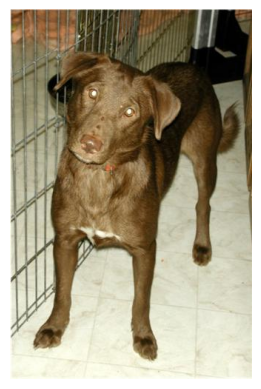

In [ ]:
predimage(Pet="Dog",Num=1)

Output Data : [[0.6619229  0.33807713]]
Predicted class: 0
Predicted class name: Cat with Confidence = 0.6619228720664978


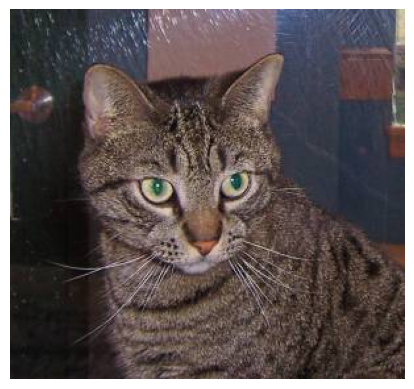

In [ ]:
predimage(Pet="Cat",Num=1)

In [ ]:
# Specify the file path to save the model
tflite_model_path = "QATModel.tflite"

# Write the model to the file
with open(tflite_model_path, 'wb') as f:
    f.write(quantized_tflite_model)

print(f"Quantized TensorFlow Lite model saved to: {tflite_model_path}")


Quantized TensorFlow Lite model saved to: QATModel.tflite


In [ ]:
# Print the size of the model
model_size = os.path.getsize(tflite_model_path)
print(f"QAT Model size: {model_size / (1024):.2f} KB")

QAT Model size: 214.47 KB
